# Spatial subset examples for several of PO.DAAC's THREDDS services in Python

This notebook follows a similar workflow to an old notebook that I did for ORNL DAAC's OGC services (included in this repo: [ogc-poly-subset.ipynb](ogc-poly-subset.ipynb)).

## Background

### Content

It's divided into three sections: 

* access subset geometry from OGR supported vector data formats,
* space, time subset using THREDDS WCS,
* polygon subset with the input vector dataset.

### Example dataset

We're gonna subset this GHRSST granule: 

https://thredds.jpl.nasa.gov/thredds/catalog/ncml_aggregation/OceanTemperature/ghrsst/catalog.html?dataset=ncml_aggregation/OceanTemperature/ghrsst/aggregate__ghrsst_JPL_OUROCEAN-L4UHfnd-GLOB-G1SST_OI.ncml


## Subset geometry

Import GDAL/OGR and read the example ESRI Shapefile (simple Gulf of Mexico polygon):

In [1]:
from osgeo import gdal, ogr, osr
from json import loads, dumps
import numpy as np

input_polygon = "example_poly/shapefile2.shp"

These steps grab the feature from the file (will also work for multiple features), and gets its spatial extent. They should work for any OGR dataset and SRS:

In [2]:
shp = ogr.Open(input_polygon)    # Open the input ESRI Shapefile (or other vector).
lyr = shp.GetLayer()             # Get the first (and only) layer.
feat = lyr.GetFeature(0)         # Get the layer's only feature.
geom = feat.GetGeometryRef()     # Get feature's geometry.
ext = lyr.GetExtent()            # Get the rectangular extent of the geometry.

ext

(-97.92333884760556, -80.9344862109354, 19.2349555158823, 30.199837703950273)

### Plot the example input polygon on a basemap

Get the polygon geometry as a JSON string and load it to a Python dictionary.

In [3]:
# Export the feature to JSON and load string to Python dictionary:
poly = loads(geom.ExportToJson())

# Get the array of coordinates from the GeoJSON dictionary:
crds = poly['coordinates'][0]

crds

[[-92.50277108026334, 29.56938225072281],
 [-83.7769790645417, 30.199837703950273],
 [-80.9344862109354, 24.928609732834346],
 [-84.63633736912035, 21.404467339404434],
 [-89.32975580181909, 21.096419248573053],
 [-91.0484724109764, 19.2349555158823],
 [-96.20462223844827, 19.297357882373674],
 [-97.92333884760556, 23.117355263556085],
 [-97.13008502799451, 27.537299169977643],
 [-92.50277108026334, 29.56938225072281]]

Get the 2d array as two lists of longitudes and latitudes, and get the xy for the polygon centroid as a tuple:

In [4]:
# Get the longitudes and latitudes as two lists.
lons = [c[0] for c in crds]
lats = [c[1] for c in crds]

# Get the centroid of the OGR Geometry:
cent = geom.Centroid()

# Prepare arguments for a new Basemap object (used by the next cell).
margs = {
    # Calculate map extent from the geometry using a 2.5-deg buffer.
    'llcrnrlat': min(lats) - 2.5,
    'llcrnrlon': min(lons) - 2.5,
    'urcrnrlat': max(lats) + 2.5,
    'urcrnrlon': max(lons) + 2.5,
    # Use the geometry centroids as the map center.
    'lat_0': cent.GetY(), 
    'lon_0': cent.GetX(),
}

margs

{'llcrnrlat': 16.7349555158823,
 'llcrnrlon': -100.42333884760556,
 'urcrnrlat': 32.69983770395027,
 'urcrnrlon': -78.4344862109354,
 'lat_0': 24.910825071802158,
 'lon_0': -89.98954251670611}

**TODO:** Re-do this plot using `cartopy`, the replacement for `mpl_toolkits.basemap`.

The subset area is shown by the gray overlay in the map below:

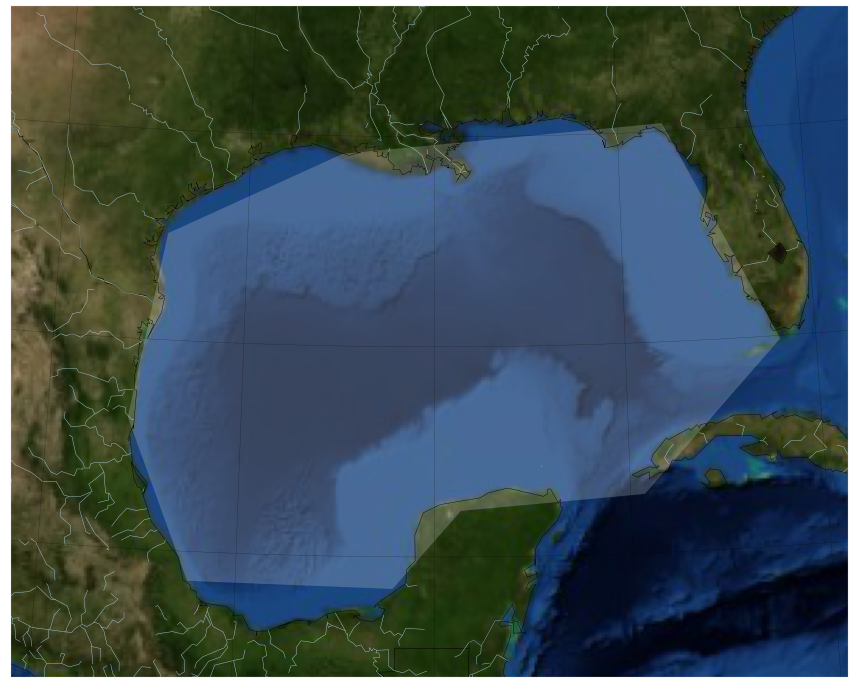

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap

# Make a matplotlib figure:
plt.figure(figsize=(15, 15))

# Create Basemap with albers equal area and low feature resolution:
m = Basemap(**margs, projection="aea", resolution="l")

# Add your preferred Basemap built-in layers,
m.bluemarble()
m.drawcountries()
m.drawrivers(color="lightblue", linewidth=0.4)
m.drawcoastlines(color="black", linewidth=0.4)
m.drawparallels(range(20, 35, 5), color="black", linewidth=0.3, alpha=0.05)
m.drawmeridians(range(-105, -75, 5), color="black", linewidth=0.3, alpha=0.05)
m.drawmapboundary(color="lightgray", linewidth=0.2)

# Convert geographic coordinates to map (i.e. plot) coordinates:
x, y = m(x=lons, y=lats)

# Zip back to a 2d array; create a matplotlib Polygon:
poly = Polygon(list(zip(x,y)), facecolor="white", alpha=0.2, linewidth=1.2)

# Then plot the polygon in red:
plt.gca().add_patch(poly)

## Get subsets of GHRSST sst data from THREDDS services

Reader note: f-string syntax introduced in python 3.6 is used repeatedly in the next section to format url strings (see: [PEP 498 -- Literal String Interpolation](https://www.python.org/dev/peps/pep-0498/)) - example:

In [6]:
service = "wcs"
f"https://thredds.jpl.nasa.gov/thredds/{service}"

'https://thredds.jpl.nasa.gov/thredds/wcs'

### OGC Web Coverage Service (WCS)

Our first subset will use the `GetCoverage` function of the WCS service. You can find the WCS `GetCapabilities` for our target granule at this URL:

https://thredds.jpl.nasa.gov/thredds/wcs/ncml_aggregation/OceanTemperature/ghrsst/aggregate__ghrsst_JPL_OUROCEAN-L4UHfnd-GLOB-G1SST_OI.ncml?service=WCS&version=1.0.0&request=GetCapabilities

Here's the THREDDS base url, and the path to our example GHRSST granule within the THREDDS catalog:

In [7]:
thredds = "https://thredds.jpl.nasa.gov/thredds"
granule = "ncml_aggregation/OceanTemperature/ghrsst/aggregate__ghrsst_JPL_OUROCEAN-L4UHfnd-GLOB-G1SST_OI.ncml"

granule

'ncml_aggregation/OceanTemperature/ghrsst/aggregate__ghrsst_JPL_OUROCEAN-L4UHfnd-GLOB-G1SST_OI.ncml'

#### `GetCoverage` parameters

Some of the input parameters to a `GetCoverage` request are informed by the spatial characteristics of the target dataset. 

https://geopython.github.io/OWSLib/

Here we open the remote dataset with the `owslib` WCS interface for Python (a WCS reference implementation, supported by OSGeo):

In [8]:
from owslib.wcs import WebCoverageService

# Format granule url and access with wcs, then list available data:
WCS = WebCoverageService(f"{thredds}/wcs/{granule}", version="1.0.0")

WCS.contents.keys()

dict_keys(['analysis_error', 'analysed_sst', 'mask'])

Now get the metadata available for `analysed_sst` as a Python dictionary and print:

In [9]:
# Get ref to the owslib.coverage for analysed_sst:
sst = WCS.contents['analysed_sst']

# You can get this information from the owslib client:
meta = [
    'abstract',
    'axisDescriptions',
    'boundingBox',
    'boundingBoxWGS84',
    'boundingboxes',
    'crsOptions',
    'defaulttimeposition',
    'grid',
    'id',
    'keywords',
    'styles',
    'supportedCRS',
    'supportedFormats',
    'timelimits',
    'title',
]

# Turn it into a dictionary:
sst_meta = {f: getattr(sst, f) for f in meta}

sst_meta

{'abstract': 'analysed_sst                  kelvin                        true  analysed sea surface temperature',
 'axisDescriptions': [],
 'boundingBox': None,
 'boundingBoxWGS84': (-179.9949951171875,
  -79.99500274658203,
  179.9949951171875,
  79.99500274658203),
 'boundingboxes': [],
 'crsOptions': None,
 'defaulttimeposition': None,
 'grid': <owslib.coverage.wcs100.RectifiedGrid at 0x7f85dc0bdfd0>,
 'id': 'analysed_sst',
 'keywords': [],
 'styles': None,
 'supportedCRS': [urn:ogc:def:crs:EPSG::, urn:ogc:def:crs:::-1],
 'supportedFormats': ['GeoTIFF', 'GeoTIFF_Float', 'NetCDF3'],
 'timelimits': ['2010-06-09T12:00:00Z', '2019-09-16T00:00:00Z'],
 'title': 'analysed sea surface temperature'}

Looking at the two CRS objects, I think that they are not being properly interpreted by the service. This one is the info for EPSG format:

In [10]:
sst_meta['supportedCRS'][0].__dict__

{'id': 'EPSG:0',
 'naming_authority': None,
 'category': None,
 'type': None,
 'authority': 'EPSG',
 'version': None,
 'code': 0,
 'axisorder': 'xy',
 'encoding': 'code'}

And the info for the URI format:

In [11]:
sst_meta['supportedCRS'][1].__dict__

{'id': '[Latitude_Longitude]',
 'naming_authority': None,
 'category': None,
 'type': None,
 'authority': None,
 'version': None,
 'code': -1,
 'axisorder': 'xy',
 'encoding': 'code'}

The object stored by the `grid` attribute describes similar information to GDAL's `osr.SpatialReference`. This info is important to consider when leveraging WCS's on-the-fly reprojection capability:

In [12]:
sst.grid.__dict__

{'axislabels': ['x', 'y'],
 'dimension': 2,
 'lowlimits': ['0', '0'],
 'highlimits': ['35999', '15999'],
 'origin': ['-179.9949951171875', '-79.99500274658203'],
 'offsetvectors': [['0.009999999728725104', '0.0'],
  ['0.0', '0.010000000343344213']]}

##### crs

WCS does geographic transform on the fly, and the `crs` parameter is required for its `GetCoverage` function. It accepts a string formatted like `EPSG:#####` when supplied in a query URL. For simplicity, we request the subset from WCS in the native projection.

*To get the subset in the projection matching your input polygon* (not advised in some contexts): GDAL `osr` spatial reference  `AutoIdentifyEPSG` method of `osr.SpatialReference` class tries to guess the EPSG based on the available SRS parameters. This is the most legit way to try to determine the EPSG code of the input dataset if it's in a custom SRS or is missing an EPSG for any other reason. Here's how you can call `AutoIdentifyEPSG` for a layer in a vector dataset:

In [13]:
# Get's osr.SpatialReference from the OGR Layer.
srs = lyr.GetSpatialRef()

# Try to lookup the EPSG of the SRS object in GDAL's reference.
srs.AutoIdentifyEPSG()

# Get the highest authority EPSG code (authority=None):
epsg = srs.GetAuthorityCode(None)

epsg

'4326'

NOTE: You get the `srs` object using the `GetProjection` or the `GetProjectionRef` methods for raster datasets.

##### time

And the time intervals are at `timepositions`:

In [14]:
sst_time = sst.timepositions

# Print some stats about sst_time:
print(f"""sst.timepositions
 type:  {type(sst_time).__name__}
 count: {len(sst_time)}
 first: {sst_time[0]}
 last:  {sst_time[-1]}
""")

sst.timepositions
 type:  list
 count: 3370
 first: 2010-06-09T12:00:00Z
 last:  2019-09-16T00:00:00Z



`offsetvectors` give the rotation and xy resolution of the cells in the grid. There should be no rotation for most datasets L3 and up, the exception being unusual projections and airborne swath derivatives. (L2 swath data aren't compatible with WCS, as far as I know. I will confirm.) 

We need to provide an input for `resx` and `resy` parameters, so use the cell resolution from `offsetvectors` (which are listed in the same order as they're given in `gdal.Dataset.GeoTransform`, GDAL's representation of the affine transform used to warp between projected and geographic systems):

In [15]:
offsetvectors = sst.grid.__dict__['offsetvectors']

offsetvectors[0][0], offsetvectors[1][1]

('0.009999999728725104', '0.010000000343344213')

Let's download the minimal amount of data required to produce a GOM subset matching the polygon shown on the map.

Use xy extent of the minimum bounding rectangle for the input polygon as input to the `bbox` parameter. Use the `sst['id']` for the `identifier` parameter, and use the `epsg` code for the `crs` parameter:

In [16]:
sst_time[0]

'2010-06-09T12:00:00Z'

#### `GetCoverage` example (Python)

In [17]:
sst_data = WCS.getCoverage(
    
    # The coverage identifier corresponds to a netCDF variable.
    identifier=sst_meta['id'],
    
    # The bbox is given in this order: (minx, miny, maxx, maxy).
    bbox=(min(lons), min(lats), max(lons), max(lats)),
    
    # Get the subset in the dataset's native coordinate system.
    crs=None,
    
    # Output in a supported format: 'GeoTIFF'. (See: 'sst_meta').
    format=sst_meta['supportedFormats'][0],
    
    # Get the x and y resolution from the nested list of cell offsets.
    resx=offsetvectors[0][0],
    resy=offsetvectors[1][1],
    
    # NEAREST is often safest/fastest interpolation, but avoid regridding here.
    interpolation='NEAREST',

)

# Write the single-band raster image to a GeoTIFF:
with open("example_outputs/wcs-python.tif", "wb") as f:
    f.write(sst_data.read())

# GDAL provides a version of 'gdalinfo' implemented in Python. Call if for the GeoTIFF:
print(gdal.Info("example_outputs/wcs-python.tif"))

Driver: GTiff/GeoTIFF
Files: example_outputs/wcs-python.tif
Size is 1700, 1097
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-97.930000305175781,30.199999809265137)
Pixel Size = (0.010000003233175,-0.009999999164665)
Metadata:
  AREA_OR_POINT=Area
  TIFFTAG_RESOLUTIONUNIT=1 (unitless)
  TIFFTAG_SOFTWARE=nc2geotiff
  TIFFTAG_XRESOLUTION=1
  TIFFTAG_YRESOLUTION=1
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  ( -97.9300003,  30.1999998) ( 97d

Boom! Confirm again that the file exists:

In [18]:
from os.path import isfile
isfile("example_outputs/wcs-python.tif")

True

#### `GetCoverage` example (curl)

We can also get an identical GeoTIFF using `curl`. This requires a carefully constructed request URL (WCS is finicky about parameters, in my experience). Fortunately, `owslib` provides the equivalent URL for the coverage that we just downloaded through the Python client.

Print the request URL with `sst_data.geturl()`:

In [19]:
wcs_url = sst_data.geturl()

wcs_url

'https://thredds.jpl.nasa.gov/thredds/wcs/ncml_aggregation/OceanTemperature/ghrsst/aggregate__ghrsst_JPL_OUROCEAN-L4UHfnd-GLOB-G1SST_OI.ncml?version=1.0.0&request=GetCoverage&service=WCS&Coverage=analysed_sst&BBox=-97.92333884760556%2C19.2349555158823%2C-80.9344862109354%2C30.199837703950273&format=GeoTIFF&resx=0.009999999728725104&resy=0.010000000343344213&interpolation=NEAREST'

In [20]:
!curl "$wcs_url" -o example_outputs/wcs-curl.tif

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1830k  100 1830k    0     0  4316k      0 --:--:-- --:--:-- --:--:-- 4316k


Get its `gdalinfo` with the command line utility:

In [21]:
!gdalinfo example_outputs/wcs-curl.tif

Warning 1: TIFFFetchNormalTag:incorrect count for field "PageNumber", expected 2, got 1
Driver: GTiff/GeoTIFF
Files: example_outputs/wcs-curl.tif
Size is 1700, 1097
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-97.930000305175781,30.199999809265137)
Pixel Size = (0.010000003233175,-0.009999999164665)
Metadata:
  AREA_OR_POINT=Area
  TIFFTAG_RESOLUTIONUNIT=1 (unitless)
  TIFFTAG_SOFTWARE=nc2geotiff
  TIFFTAG_XRESOLUTION=1
  TIFFTAG_YRESOLUTION=1
Image Structure Metadat

Last, but not least, GDAL provides direct access (through `curl`) to the remote dataset with its virtual filesystem interface (VSI). Prefix the URL with `/vsicurl/` for direct access to the data over WCS:

In [24]:
wcs_ras = gdal.Open(f"/vsicurl/{wcs_url}")

wcs_ras

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f85aa488660> >

Get spatial extent in the native projection for our plot axes:

In [23]:
# Get the xy dimensions:
ncols = wcs_ras.RasterXSize
nrows = wcs_ras.RasterYSize

# Get the warped raster's geotransformation as its component parts:
xmin, xres, xrot, ymax, yrot, yres = wcs_ras.GetGeoTransform()

# Get the xmax and ymin:
xmax = xmin + ncols*xres
ymin = ymax + nrows*yres

[xmin, ymin, xmax, ymax]

[-97.93000030517578,
 19.230000725627814,
 -80.92999480877855,
 30.199999809265137]

Get the WCS raster's array:

In [25]:
wcs_arr = wcs_ras.GetRasterBand(1).ReadAsArray()

wcs_arr

array([[  0,   0,   0, ..., 162, 162, 162],
       [  0,   0,   0, ..., 162, 162, 162],
       [  0,   0,   0, ..., 162, 163, 163],
       ...,
       [  0,   0,   0, ..., 200, 200, 200],
       [  0,   0,   0, ..., 200, 200, 200],
       [  0,   0,   0, ..., 200, 200, 200]], dtype=uint8)

Plot the sea surface temperature raster that we just retrieved:

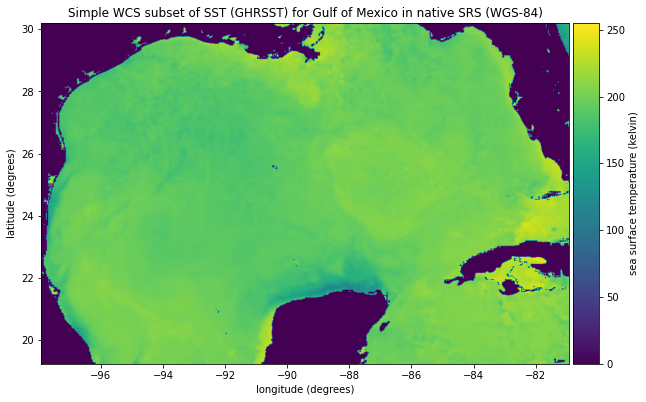

In [26]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Make a matplotlib figure, get an auxilliary plot axis, render raster array as image:
plt.figure(figsize=(10, 15))
ax = plt.gca()
im = plt.imshow(wcs_arr, extent=[xmin, xmax, ymin, ymax])

# Update title and other plot aesthetics:
plt.ticklabel_format(style='plain')
plt.title("Simple WCS subset of SST (GHRSST) for Gulf of Mexico in native SRS (WGS-84)")
plt.xlabel("longitude (degrees)")
plt.ylabel("latitude (degrees)")

# Format the auxilliary axis and stick a colorbar in there:
divider = make_axes_locatable(ax)
cb = plt.colorbar(im, cax=divider.append_axes("right", size="5%", pad=0.05))
cb.set_label("sea surface temperature (kelvin)")

### Mask the raster with the input polygon

Use the dimensions, resolution, and spatial reference information of the GeoTIFF returned by WCS. The input polygon has to be reprojected if its SRS info doesn't match what was requested from WCS.

#### Making a mask

We create a mask from the input polygon. The values inside hte polygon are `1` and outside `0`. **This is a key step because we are producing a raster mask that aligns perfectly with the grid of the source data.** 

1. Make an new raster dataset in memory that shares the same grid as the retrieved WCS granule.
2. Fill it will zeros and set the fill value 0.
3. Rasterize the polygon on the grid of the new dataset.

Then display the truncated `numpy` array in the masked raster dataset:

In [27]:
# Make an empty raster dataset in memory:
mask = gdal.GetDriverByName('MEM').Create("", ncols, nrows, 1, gdal.GDT_Byte, )

# Copy the transform and projections from the WCS raster:
mask.SetGeoTransform(wcs_ras.GetGeoTransform())
mask.SetProjection(wcs_ras.GetProjection())

# Get band one, fill it with zeros and set no data to 0:
mask_band = mask.GetRasterBand(1)
mask_band.Fill(0)
mask_band.SetNoDataValue(0)

# Rasterize input polygon (band==[1]), and 'write' changes to mask dataset:
err = gdal.RasterizeLayer(mask, [1], lyr, burn_values=[1])
mask.FlushCache()

# Get the mask array from band one:
mask_arr = mask.GetRasterBand(1).ReadAsArray()

# Close the mask raster dataset.
mask = None

mask_arr

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Make a crudge plot of the mask:

Text(0, 0.5, 'latitude (degrees)')

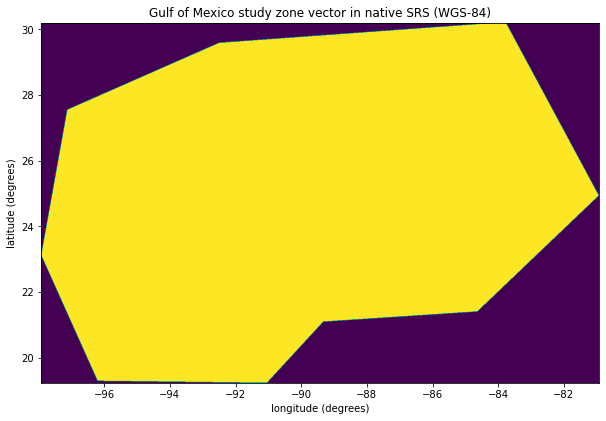

In [28]:
# Make matplotlib figure, get an auxilliary plot axis, render mask array as image:
plt.figure(figsize=(10, 15))
im = plt.imshow(mask_arr, extent=[xmin, xmax, ymin, ymax])

# Update title and other plot aesthetics:
plt.ticklabel_format(style='plain')
plt.title("Gulf of Mexico study zone vector in native SRS (WGS-84)")
plt.xlabel("longitude (degrees)")
plt.ylabel("latitude (degrees)")

#### Apply the mask to the WCS raster.

Finally, make a numpy masked array (used by GDAL for its masked array representation):

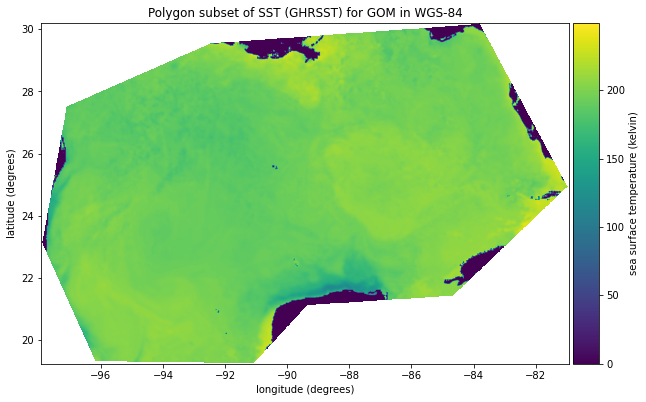

In [30]:
wcs_mask_arr = np.ma.masked_where(mask_arr==0, wcs_arr)

# Make a matplotlib figure, get an auxilliary plot axis, render raster array as image:
plt.figure(figsize=(10, 15))
ax = plt.gca()
im = plt.imshow(wcs_mask_arr, extent=[xmin, xmax, ymin, ymax])

# Update title and other plot aesthetics:
plt.ticklabel_format(style='plain')
# Update title and other plot aesthetics:
plt.title("Polygon subset of SST (GHRSST) for GOM in WGS-84")
plt.xlabel("longitude (degrees)")
plt.ylabel("latitude (degrees)")

# Format the auxilliary axis and stick a colorbar in there:
divider = make_axes_locatable(ax)
cb = plt.colorbar(im, cax=divider.append_axes("right", size="5%", pad=0.05))
cb.set_label("sea surface temperature (kelvin)")

Make a new GeoTIFF dataset and write the masked data to it.

In [31]:
# Make a new raster to store the masked raster dataset.
mask_ras = gdal.GetDriverByName('GTiff').Create(
    "example_outputs/wcs-masked.tif", ncols, nrows, 1, gdal.GDT_Float32)

# Copy the transform and projections from the WCS raster:
mask_ras.SetGeoTransform(wcs_ras.GetGeoTransform())
mask_ras.SetProjection(wcs_ras.GetProjection())

# Get band one, fill it with zeros and set no data to 0:
mask_ras_band = mask_ras.GetRasterBand(1)
mask_ras_band.SetNoDataValue(-9999.)

# Add the masked data to the raster band and write to disk.
mask_ras_band.WriteArray(wcs_mask_arr)
mask_ras.FlushCache()

# Close the file.
mask_ras = None

Check its `gdal.Info`:

In [32]:
print(gdal.Info("example_outputs/wcs-masked.tif"))

Driver: GTiff/GeoTIFF
Files: example_outputs/wcs-masked.tif
Size is 1700, 1097
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-97.930000305175781,30.199999809265137)
Pixel Size = (0.010000003233175,-0.009999999164665)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  ( -97.9300003,  30.1999998) ( 97d55'48.00"W, 30d12' 0.00"N)
Lower Left  ( -97.9300003,  19.2300007) ( 97d55'48.00"W, 19d13'48.00"N)
Upper Right ( -80